<a href="https://colab.research.google.com/github/ravi02512/AM-Expert-Analytics-Vidhya-Hackathon/blob/master/Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive 
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [0]:
import pandas as pd
import numpy as np

train=pd.read_csv('/content/gdrive/My Drive/null_False_final.csv')
# X=train.drop('redemption_status', axis=1)
# y=train['redemption_status']

In [0]:
import os 
os.chdir('/content/gdrive/My Drive')

In [0]:
params={'bagging_fraction': 0.8014441163511778,
        'feature_fraction': 0.887446475418968,
        'n_estimators':2000,
         'lambda_l1': 0.0006907693477425925,
         'lambda_l2': 0.00932080129051771,
         'max_depth': 7,
         'min_child_weight': 5.095015806849857,
         'min_split_gain': 0.03327364999635955,
         'num_leaves': 42}

In [0]:
import gc
def kfold_lightgbm(df, num_folds, stratified = False, save= False):
    # Divide in training/validation and test data
    train_df = train[train['redemption_status'].notnull()]
    test_df = train[train['redemption_status'].isnull()]
    print("Starting LightGBM. Train shape: {}, test shape: {}".format(train_df.shape, test_df.shape))
  
    gc.collect()
    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits= num_folds, shuffle=True, random_state=1001)
    else:
        folds = KFold(n_splits= num_folds, shuffle=True, random_state=1001)
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in ['redemption_status','customer_id','coupon_id','item_id', 'campaign_id','index', 'id']]
    
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['redemption_status'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['redemption_status'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['redemption_status'].iloc[valid_idx]

#   # LightGBM parameters found by Bayesian optimization

        
        clf =LGBMClassifier(**params)
        
        
        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 500)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = clf.feature_importances_
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y
        gc.collect()

    print('Full AUC score %.6f' % roc_auc_score(train_df['redemption_status'], oof_preds))
    # Write submission file and plot feature importance
    if save:
        test_df['redemption_status'] = sub_preds
        test_df[['id', 'redemption_status']].to_csv('AMD5final_submission.csv', index= False)
    display_importances(feature_importance_df)
    return feature_importance_df, test_df[['id', 'redemption_status']]

# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')

Starting LightGBM. Train shape: (78369, 716), test shape: (50226, 716)
Training until validation scores don't improve for 500 rounds.
[200]	training's binary_logloss: 0.0308569	training's auc: 0.969419	valid_1's binary_logloss: 0.0406191	valid_1's auc: 0.908894
[400]	training's binary_logloss: 0.0308554	training's auc: 0.969409	valid_1's binary_logloss: 0.0406183	valid_1's auc: 0.908914
Early stopping, best iteration is:
[34]	training's binary_logloss: 0.0337389	training's auc: 0.960102	valid_1's binary_logloss: 0.0391372	valid_1's auc: 0.909953
Fold  1 AUC : 0.909953
Training until validation scores don't improve for 500 rounds.
[200]	training's binary_logloss: 0.030628	training's auc: 0.970115	valid_1's binary_logloss: 0.0416646	valid_1's auc: 0.901449
[400]	training's binary_logloss: 0.030628	training's auc: 0.970115	valid_1's binary_logloss: 0.0416646	valid_1's auc: 0.901449
Early stopping, best iteration is:
[37]	training's binary_logloss: 0.0334529	training's auc: 0.961127	valid_

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


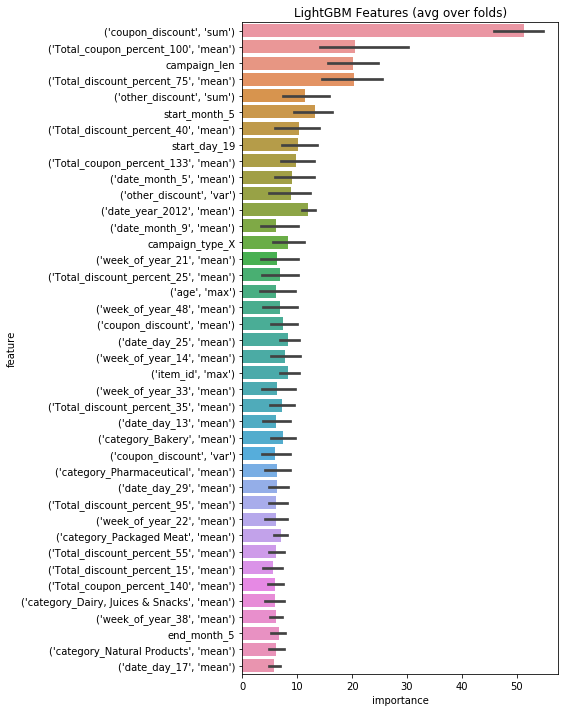

In [13]:
a, b=kfold_lightgbm(train, 5, stratified = True, save= True)